In [12]:
import networkx as nx
import numpy as np
import random 

from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from conet.data_converter.corrected_counts import CorrectedCounts
from conet.data_converter.data_converter import DataConverter
from conet import CONET, CONETParameters, InferenceResult
from conet.generative_model import CNSampler, EventTree, CountsGenerator, EventTreeGenerator

bin_dir = "./" # path to dir with CONET executable
loci = 1000
tree_size = 10
cells = 260

random.seed(2234)
np.random.seed(234)

In [13]:
# generate event tree and cell data
cn_s = CNSampler.create_default_sampler()
t_gen = EventTreeGenerator(cn_sampler=cn_s, tree_size=tree_size, no_loci=loci)
tree: EventTree = t_gen.generate_random_tree()
d_gen = CountsGenerator(cn_s, tree)
counts, attachment, corrected_counts, brkp_matrix = d_gen.generate_data(loci, cells)

2022-05-21 11:54:11,384 — conet.generative_model.event_tree_generator — INFO — Starting event tree generation...
2022-05-21 11:54:11,385 — conet.generative_model.event_tree_generator — INFO — Sampled size of trunk equal to 4.
2022-05-21 11:54:11,385 — conet.generative_model.event_tree_generator — INFO — Successfully sampled unvalidated event tree structure.
2022-05-21 11:54:11,386 — conet.generative_model.event_tree — INFO — Testing validity of generated tree...
2022-05-21 11:54:11,389 — conet.generative_model.event_tree — INFO — Tree has non-identifiable breakpoint loci. Validation failed.
2022-05-21 11:54:16,648 — conet.generative_model.event_tree_generator — INFO — Starting event tree generation...
2022-05-21 11:54:16,649 — conet.generative_model.event_tree_generator — INFO — Sampled size of trunk equal to 2.
2022-05-21 11:54:16,650 — conet.generative_model.event_tree_generator — INFO — Successfully sampled unvalidated event tree structure.
2022-05-21 11:54:16,650 — conet.generative

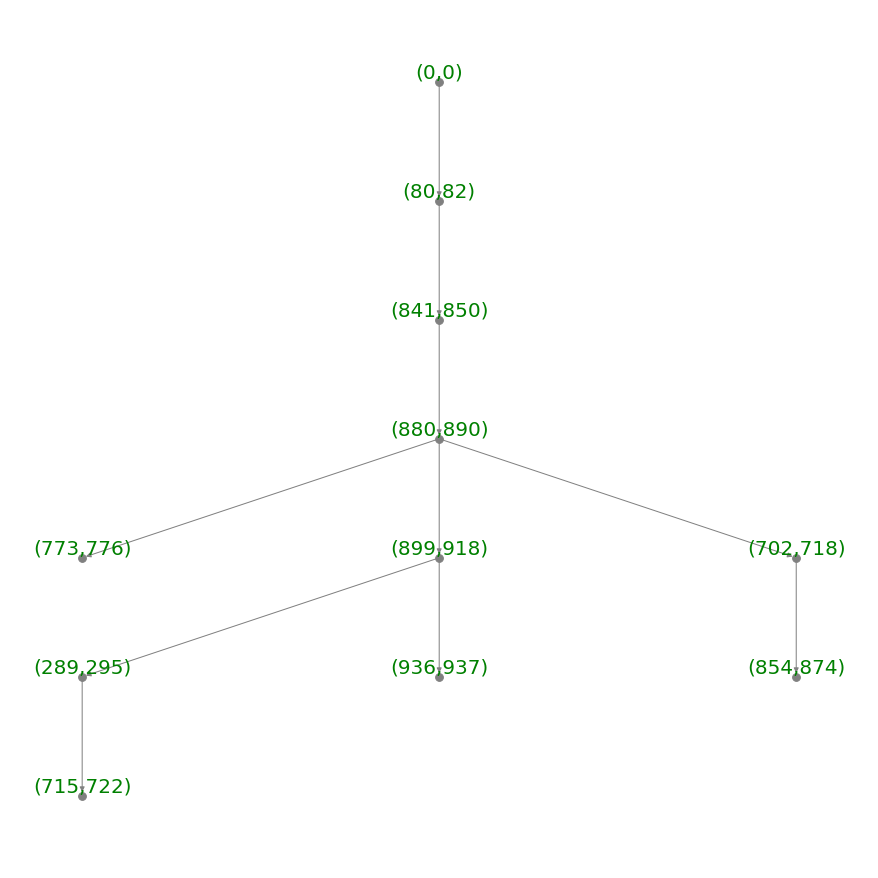

In [14]:
# Draw simulated tree
plt.figure(3, figsize=(12, 12))
pos = graphviz_layout(tree.tree, prog="dot")
nx.draw(tree.tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")
plt.show()

In [15]:
# Convert corrected counts dataframe to input files for CONET 
cc = CorrectedCounts(corrected_counts)
DataConverter(event_length_normalizer=loci).create_CoNET_input_files(out_path=bin_dir, corrected_counts=cc)

In [16]:
# Run CONET
conet = CONET(bin_dir + "CONET")
params = CONETParameters(tree_structure_prior_k1=0.5, data_dir=bin_dir, counts_penalty_s1=100000,
                         counts_penalty_s2=100000,
                         param_inf_iters=200000, seed=2167, mixture_size=2, pt_inf_iters=500000,
                         use_event_lengths_in_attachment=False,
                         event_length_penalty_k0=1, output_dir = "./output/")
conet.infer_tree(params)

2022-05-21 11:54:29,066 — conet.conet — INFO — CONET log: b'Input files have been loaded succesfully\n'
2022-05-21 11:54:29,604 — conet.conet — INFO — CONET log: b'Starting parameter estimation\n'
2022-05-21 11:55:17,251 — conet.conet — INFO — CONET log: b'Finished parameter estimation\n'
2022-05-21 11:55:17,251 — conet.conet — INFO — CONET log: b'Estimated breakpoint distribution:\n'
2022-05-21 11:55:17,252 — conet.conet — INFO — CONET log: b'(weight: 1 mean: 1.02366sd: 0.39203)\n'
2022-05-21 11:55:17,252 — conet.conet — INFO — CONET log: b'\n'
2022-05-21 11:55:17,253 — conet.conet — INFO — CONET log: b'Estimated no-breakpoint distribution:\n'
2022-05-21 11:55:17,253 — conet.conet — INFO — CONET log: b'mean: 0 sd: 0.437971\n'
2022-05-21 11:55:17,253 — conet.conet — INFO — CONET log: b'\n'
2022-05-21 11:55:17,255 — conet.conet — INFO — CONET log: b'State after 0 iterations:\n'
2022-05-21 11:55:17,255 — conet.conet — INFO — CONET log: b'Tree size: 5\n'
2022-05-21 11:55:17,255 — conet.co

In [17]:
result = InferenceResult('./output/', cc)

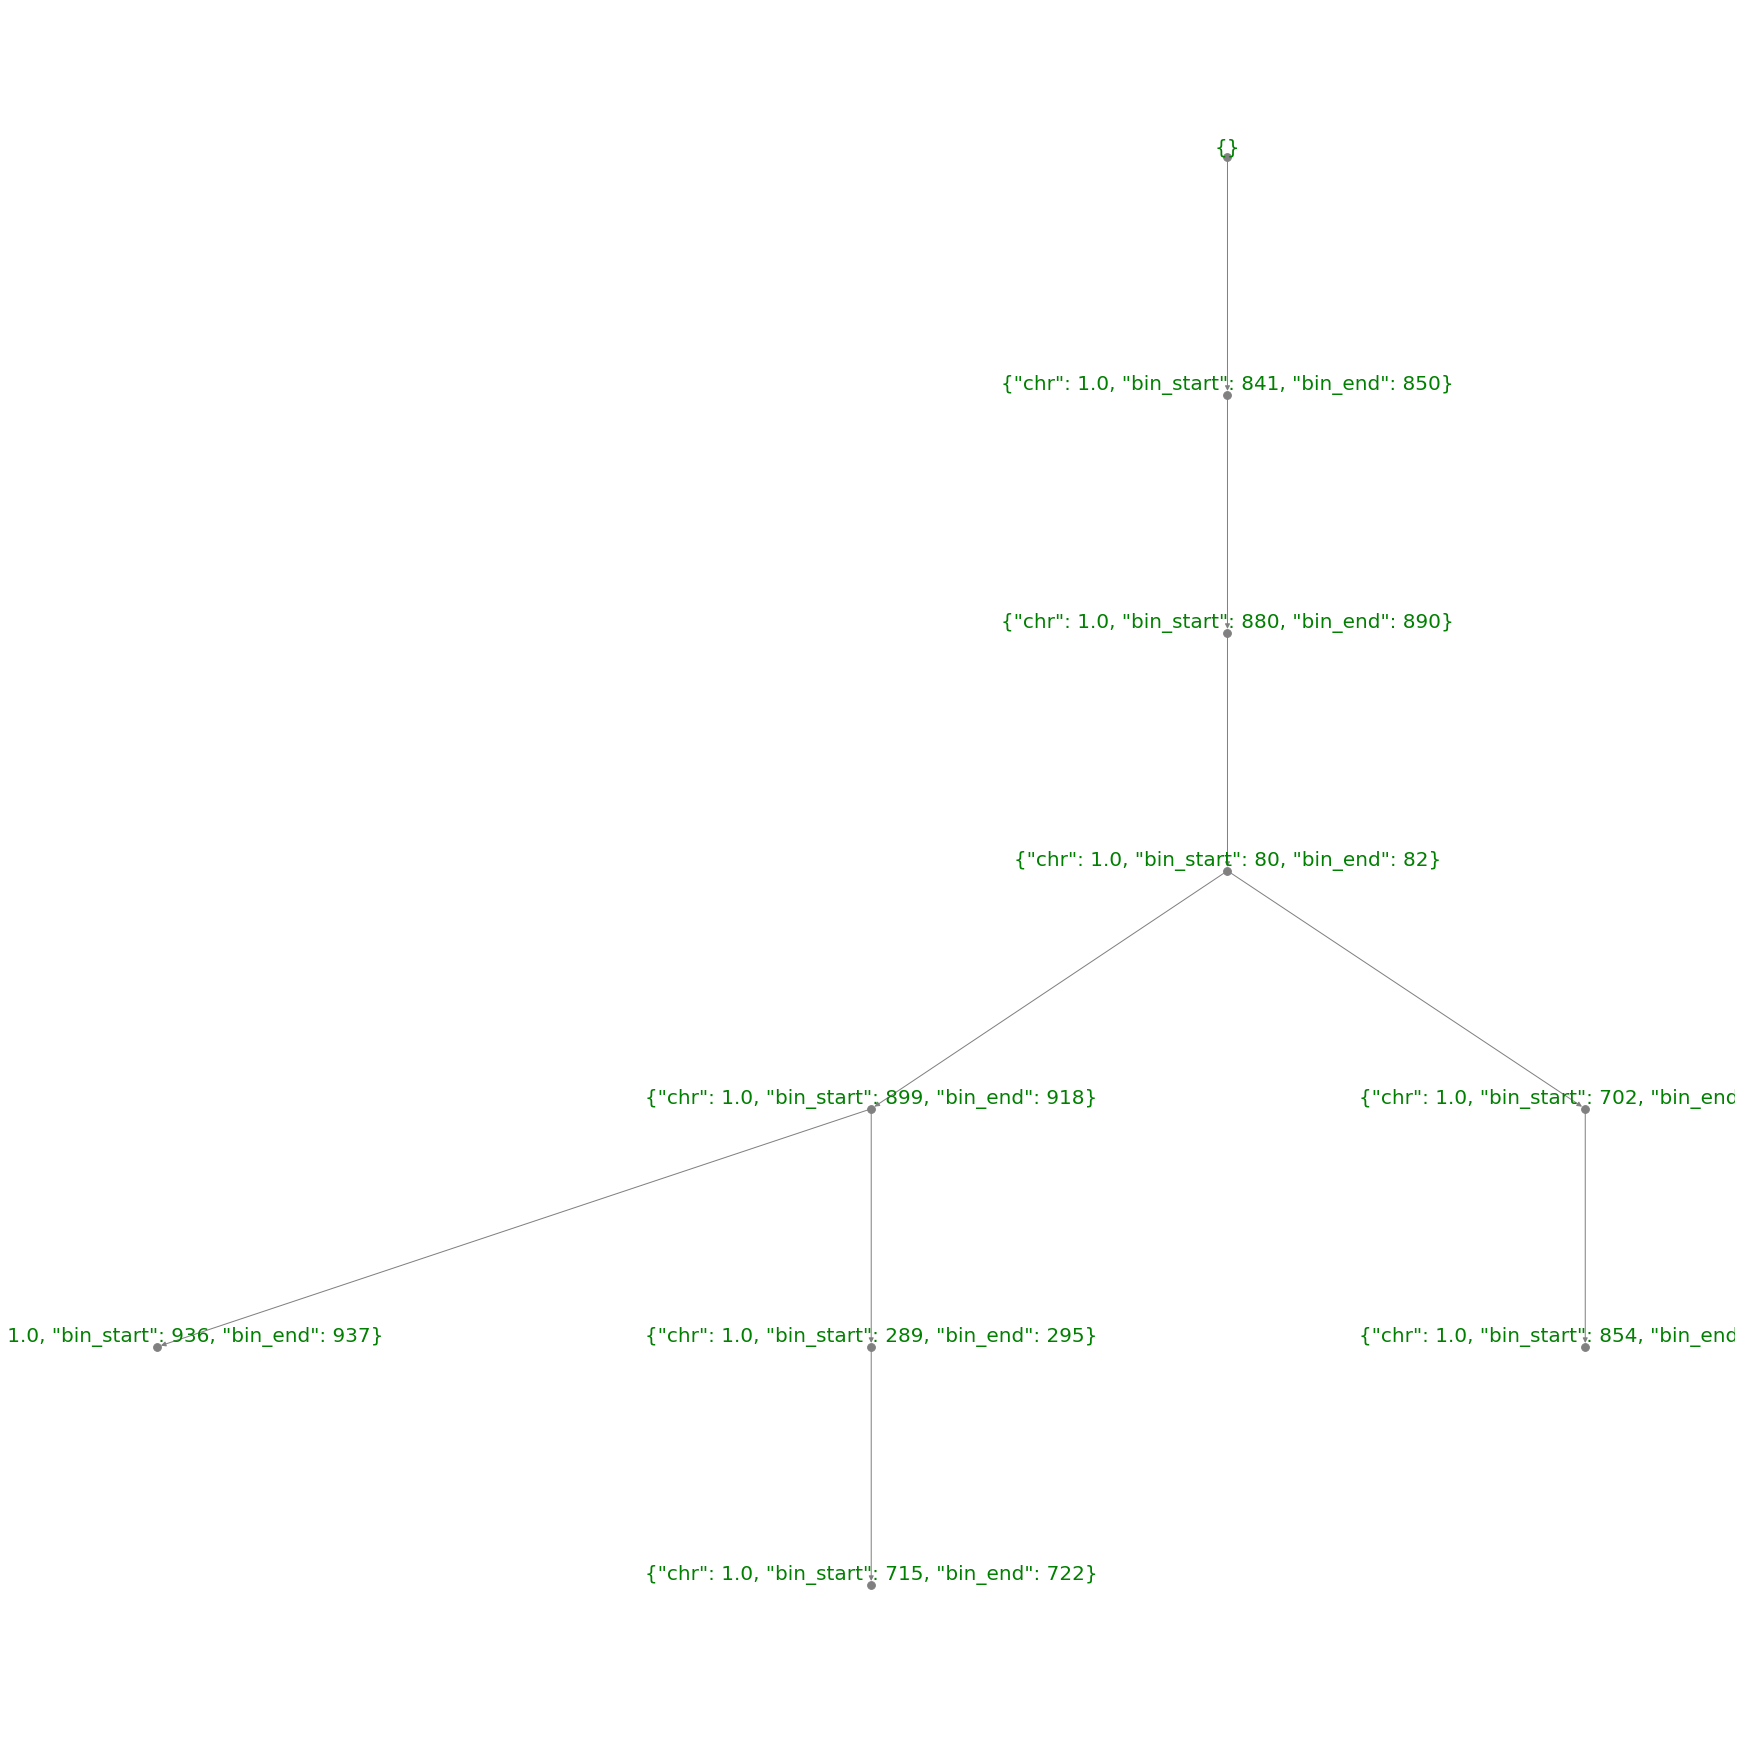

In [20]:
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(result.inferred_tree, prog="dot")
nx.draw(result.inferred_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")
plt.show()

In [19]:
# Additionally one can compare estimated and real copy number profiles... 
inferred_counts = np.transpose(result.get_inferred_copy_numbers(neutral_cn=2))
real_counts = counts

In [21]:
attachment = result.attachment

In [22]:
# cell number (cells are numbered from 0) 10 is attached to:
attachment[10]

{'chr': 1.0, 'bin_start': 715, 'bin_end': 722}